In [13]:
import torch
import random
import math

In [14]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [15]:
def inspect(tensor: torch.Tensor):
    # Just gives some properties on a given tensor - made for myself
    print(f"Type: {type(tensor)}, {tensor.type()}")
    print(f"Size: {tensor.shape}, {tensor.size()}") # Omg but there's torch.size()??
    print(tensor)


In [16]:
# Playing with torch
test = torch.Tensor([[1,2,3,4],
                    [1,2,3,4]]
                    )
inspect(test)

Type: <class 'torch.Tensor'>, torch.FloatTensor
Size: torch.Size([2, 4]), torch.Size([2, 4])
tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.]])


In [17]:
# https://discuss.pytorch.org/t/difference-between-torch-tensor-and-torch-tensor/30786 torch.Tensor vs torch.tensor.

# Basically our values are just scalar so Tensor([2.0]) is how we do that in tensors( and torch likes tensors)
# # Double to change from default 32bit to 64 bit.
#  You set the requires grad to true because pytorch does efficiency on leaf nodes, as usuallly
# we only do leaf nodes for inputs/outputs, which don't need grads. But here we use them as actual nodes so yeah.
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) # Data is the single scalar tensor, .item() just rips it out of the tensor.
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [18]:
print(o.data.item()) # Get o.data and rip it out of the tensor 
## HOOO I JUST SET KEYBIND CTRL+Shift+P ENCASES THING WITH PRINT


0.7071066904050358


Now we'll start constructing neurons and progressively higher level using pytorch stuff. The structure of a basic neural network looks like this:
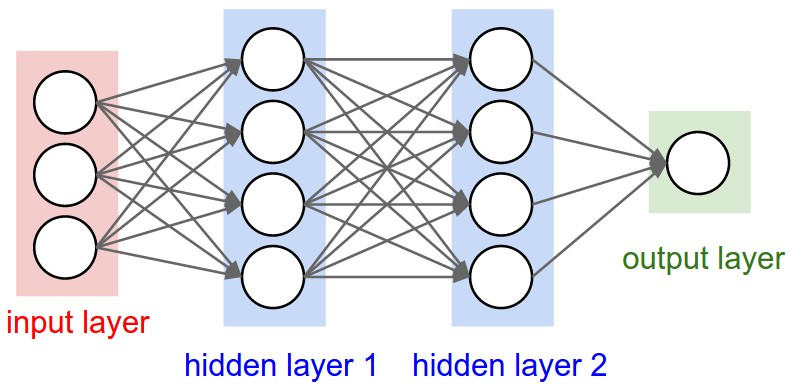

In [132]:
class Neuron:

    def __init__(self, nin: int): # nin -> number of inputs (to the neuron)
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # weights, vector of size nin.
        self.b = Value(random.uniform(-1,1)) # bias - how trigger happy are we?


    def __call__(self, x):
        # w * x + b, x is inputs from the past layer that goes into this neuron
        # Zip attaches each weight with an input (w1, x1), (w2, x2),... See its docs!
        activation = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        # act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b) || More efficient way of writing above (sum takes optional starting parameter)
        # print(activation)
        output = activation.tanh() # maps R -> (-1, 1)
        return output

        # chad way of writing that -- start with for wi, xi in zip... We want to* together, sum that, then add b.
        # So you write that code 'inside out' basically :o
        
    def parameters(self):
        return self.w + [self.b]

In [105]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9133987044067468)

In [133]:
"""A layer is literally just a list of neurons. Seriously, think about it."""
# https://www.youtube.com/watch?v=VMj-3S1tku0&t=6015s 1:48:40
class Layer:
    def __init__(self, nin, nout):
        """
        nin - # of inputs FOR EACH NEURON (or dimensionality, or: which, in a fully connected network, is also our # neurons of previous layer :o) 
        nout - # of neurons in the layer
        
        """
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs 
        # returns is that instead of just 'outs' because
        # it was added later so we can get the raw value if the output layer is the final one 

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = [] 
        # for neuron in self.neurons:
        #     params.extend(neuron.parameters())
        # return params

In [107]:
x = [2.0, 3.0]
layer = Layer(2,3)
print(layer(x))

[Value(data=-0.8960775421023314), Value(data=-0.9837368919363881), Value(data=0.6672349856472707)]


In [134]:
class MLP:
    """A set of layers... My god! The whole shabang in one"""

    def __init__(self, nin, nouts: list):
        """
        nin - number of inputs (for beginning, our first layer)
        nouts - list of sizes of all other layers in the MLP. Length of this = number of layers.
        """
        sz = [nin] + nouts # [3] + [4,5,6] -> [3,4,5,6]
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [213]:
# To reimplement that picture, we want: 3 inputs, 2 hidden layers of 4 neurons each, then 1 output
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4,4,1])
mlp(x) # A whole forward pass of our MLP!

Value(data=0.5821229585652559)

In [197]:
len(mlp.parameters())

41

## Actually making it do something
Now that we've made our neural network, let's try a baby example with some list of predictions, 
and our labels / true values -- what we want the neural net to evaluate them to.

In [214]:
xs = [
    [2.0, 3.0, -1.0], # goal for NN to output 1.0 here
    [3.0, -1.0, 0.5], # goal for NN to output -1.0 here
    [0.5, 1.0, 1.0], # .. -1.0
    [1.0, 1.0, -1.0] # 1.0... Just arbitrarily defined by us below.
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [mlp(x) for x in xs]
print(ypred)

[Value(data=0.5821229585652559), Value(data=0.6473775968316754), Value(data=0.5371168504932385), Value(data=0.6838070417457067)]


So, how do we change the weights such that we can change our predictions to fit the target?

The way we do it in deep learning is to get a single number that somehow measures the *total* performance of the model, and we try to optimise it (loss anybody UWu! We minimise this mofo). Yes, it's called loss.

In [199]:
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred)) # Pair up y ground truth, predictions. And for each, minus them (get the difference between them) 
#and square them (map them to positive nums :P, and squaring makes it easy to diff later)
print(f"Loss for each prediction: {[(yout-ygt)**2 for ygt, yout in zip(ys, ypred)]}") # Nice little showcase of loss for each prediction
loss

Loss for each prediction: [Value(data=0.2276741608896911), Value(data=3.7212960418679577), Value(data=2.480470024623688), Value(data=0.42177992755766974)]


Value(data=6.851220154939006)

In [200]:
loss.backward() # magic happens here

In [212]:
print(mlp.layers[0].neurons[0].w[0].grad)
print(mlp.layers[0].neurons[0].w[0].data) 

#Woah, it's negative! So increasing this particular weight of this neuron, of this layer, would make loss go down
# For some others, it would be +ve, so increasing the weight of that neuron would make loss go up! 

-7.3954543865104805
5.554023416279984


In [202]:
# After every loss backwards, we update the weights!
# Now we'll go nudge every weight a based on its gradient info. 
# At this point we added out the parameter method to our NN classes
loss.backward()
for p in mlp.parameters():
    p.data += -0.01 * p.grad # -0.01. Ex: if our grad is negative. We want to INCREASE the actual data, because negative grad means "dN/dL = -ve, increasing this gives lower loss."
    # You get it? dN/dL is rate of change for each increase of N. So if a gradient is negative, then, making that data more POSITIVE means that the loss will be further reduced.

In [176]:
# Our new loss values:
ypred = [mlp(x) for x in xs] # new preds using updated weights
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred)) 
print(f"Loss for each prediction: {[(yout-ygt)**2 for ygt, yout in zip(ys, ypred)]}") # Nice little showcase of loss for each prediction
loss
# Holy shit it's lower!!!

Loss for each prediction: [Value(data=3.860601968917557e-21), Value(data=0.08523975361823484), Value(data=3.9999999997458904), Value(data=4.467033541600889e-21)]


Value(data=4.085239753364125)

In [222]:
# So gradient descent is - forward pass, backward pass, update
ypred = [mlp(x) for x in xs] # new preds using updated weights
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred)) 
loss.backward()
for p in mlp.parameters():
    p.data += -0.01 * p.grad
print(f"loss: {loss}, ypred {ypred}")
# Right now, our loss is 0.04 and our predictions are basically almost perfect: 0.91, -0.82, -0.96, 0.9

loss: Value(data=0.026448197982728613), ypred [Value(data=0.9465833185492943), Value(data=-0.8637255494392542), Value(data=-0.9761637745123921), Value(data=0.9332469880500273)]


In [224]:
mlp.parameters() # The settings of weights and biases that makes our network map to the targets 

[Value(data=-0.2000968428757209),
 Value(data=0.546266281785837),
 Value(data=0.3669745962369729),
 Value(data=-0.3866224919570346),
 Value(data=0.7134388297383896),
 Value(data=-0.1546980915841306),
 Value(data=-0.6933770582959904),
 Value(data=0.5180889683495319),
 Value(data=1.271661206302905),
 Value(data=-0.07187342968625272),
 Value(data=-0.6556395205604252),
 Value(data=-0.0424168113329443),
 Value(data=-0.22138902982259967),
 Value(data=1.1194768244709972),
 Value(data=-1.2290454869504195),
 Value(data=-0.6803145008507927),
 Value(data=-1.0785445037913606),
 Value(data=-0.30257441399584317),
 Value(data=0.41389729284988086),
 Value(data=-1.6660111285807497),
 Value(data=-0.14402287709666872),
 Value(data=0.45715271792515805),
 Value(data=0.018690625689888336),
 Value(data=-1.1694829899409371),
 Value(data=-0.1261768810879726),
 Value(data=0.5037360631211466),
 Value(data=-0.3832861009798598),
 Value(data=0.5002072186387307),
 Value(data=0.4702296594788346),
 Value(data=1.176300

We just trained a neural net 😳.
## Laying everything out, training it from scratch
Okay, now let's lay it out respectably lmao instead of stuff everywhere.
I'm gonna start a bit earlier than he does, from the class definitions (load them and the rest is down here). 

In [228]:
# Model
n = MLP(3, [4,4,1]) # I don't wanna kill my mlp variable with it's weights :sob:

# Data 
xs = [
    [2.0, 3.0, -1.0], # goal for NN to output 1.0 here
    [3.0, -1.0, 0.5], # goal for NN to output -1.0 here
    [0.5, 1.0, 1.0], # .. -1.0
    [1.0, 1.0, -1.0] # 1.0... Just arbitrarily defined by us below.
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# Training - forward pass, walk it back (i.e backward pass), update weights
for k in range(20):
    # Forward pass
    ypred = [n(x) for x in xs] # new preds using updated weights
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred)) # get loss -- value telling us diff between true and predicted
    
    # Backward pass -- find out the gradients (w.r.t Loss) for each node.
    # We must zero.grad before backward!! -- Reset the gradients to 0, or else the grads just add up!
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # Update weights - gradient descent
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(f"step: {k}, loss: {loss.data}")
    


step: 0, loss: 2.771002322074189
step: 1, loss: 1.8710815782894443
step: 2, loss: 0.7061473932375129
step: 3, loss: 0.3606343667916045
step: 4, loss: 0.22639209457959045
step: 5, loss: 0.17849749000254544
step: 6, loss: 0.1469018245923348
step: 7, loss: 0.12438426549188807
step: 8, loss: 0.10757688386429969
step: 9, loss: 0.09458851101468543
step: 10, loss: 0.08427266971663203
step: 11, loss: 0.07589554765848118
step: 12, loss: 0.0689667976237959
step: 13, loss: 0.06314695439998726
step: 14, loss: 0.05819392403831507
step: 15, loss: 0.05393063255636369
step: 16, loss: 0.050224709560458686
step: 17, loss: 0.04697530666943826
step: 18, loss: 0.044104299296886355
step: 19, loss: 0.04155026637229931


In [242]:
ypred
n([1,2,-3])

Value(data=0.9299360253369785)